# Voter Data Analysis and Visualization from the 2022 federal election

#### Tuguldur Ganbat

#### 2024-12-03

**Q1) (1 mark) Based on the voter data from the 2022 federal election,
which electorates were won by Independent candidates?**

``` r
# Step 1: Read the CSV data from the provided URL, skipping the first row
election_data <- read_csv("https://results.aec.gov.au/27966/Website/Downloads/HouseDopByDivisionDownload-27966.csv", skip = 1)

# Step 2: Filter the data
election_data <- election_data |>
  filter(
    CalculationType == "Preference Count" &  
    Elected == "Y" &  
    CountNumber == 0 &  
    PartyNm == "Independent"  
  ) |>
  mutate(DivisionNm = toupper(DivisionNm))  

# Step 3: Select DivisionNm column
election_data %>% 
  select(DivisionNm)
```

    ## # A tibble: 10 × 1
    ##    DivisionNm  
    ##    <chr>       
    ##  1 FOWLER      
    ##  2 MACKELLAR   
    ##  3 NORTH SYDNEY
    ##  4 WARRINGAH   
    ##  5 WENTWORTH   
    ##  6 CLARK       
    ##  7 GOLDSTEIN   
    ##  8 INDI        
    ##  9 KOOYONG     
    ## 10 CURTIN

**Q2) (1 mark) How many of these were formerly liberal seats that were
lost to independents in 2022?**

``` r
# Step 1: Read the CSV data from the provided URL, skipping the first row
election_data_2019 <- read_csv("https://results.aec.gov.au/24310/Website/Downloads/HouseDopByDivisionDownload-24310.csv", skip = 1)

# Step 2: Filter the data
election_data_2019 = election_data_2019 |>
  filter(
    CalculationType == "Preference Count" &  
    Elected == "Y" &  
    CountNumber == 0  
  ) |>
  mutate(DivisionNm = toupper(DivisionNm))  

# Step 3: Filter election_data_2019
election_data_2019 %>% 
  filter(
    PartyAb == "LP" &  
    DivisionNm %in% c(
      "FOWLER", "MACKELLAR", "NORTH SYDNEY", "WARRINGAH",
      "WENTWORTH", "CLARK", "GOLDSTEIN", "INDI", "KOOYONG", "CURTIN"
    )  
  ) %>%
  select(DivisionNm) 
```

    ## # A tibble: 6 × 1
    ##   DivisionNm  
    ##   <chr>       
    ## 1 MACKELLAR   
    ## 2 NORTH SYDNEY
    ## 3 WENTWORTH   
    ## 4 GOLDSTEIN   
    ## 5 KOOYONG     
    ## 6 CURTIN

**Q3) (5.5 marks) Chose one of the independent electorates won in the
2022 election. Create plot(s) showing the age, income and gender
distribution of this electorates voters. Explain your steps and any
assumptions you make in your analysis. Create the same plot(s) using
data for the entire state and compare your results.**

``` r
# Step 1: Set the path for the census data
census_path <- here::here("data/2021_GCP_all_for_VIC_short-header/2021 Census GCP All Geographies for VIC")

# Step 2: Define paths for SA1, STE, and CED files
SA1_paths <- glue::glue(census_path, "/{geo}/VIC/2021Census_G17{alpha}_VIC_SA1.csv",
                        geo = "SA1", alpha = c("A", "B", "C"))

STE_paths <- glue::glue(census_path, "/{geo}/VIC/2021Census_G17{alpha}_VIC_STE.csv",
                        geo = "STE", alpha = c("A", "B", "C"))

CED_paths <- glue::glue(census_path, "/{geo}/VIC/2021Census_G17{alpha}_VIC_CED.csv",
                        geo = "CED", alpha = c("A", "B", "C"))

# Step 3: Read and pivot_longer SA1 data
tbl_G17A_long <- read_csv(CED_paths[1]) |>
  pivot_longer(cols = -1, names_to = "category",
               values_to = "count")

# Step 4: Read and pivot_longer STE data
tbl_G17B_long <- read_csv(CED_paths[2]) |>
  pivot_longer(cols = -1, names_to = "category",
               values_to = "count")

# Step 5: Read and pivot_longer CED data
tbl_G17C_long <- read_csv(CED_paths[3]) |>
  pivot_longer(cols = -1, names_to = "category",
               values_to = "count")

# Step 6: Combine all the data together
tbl_G17_long <- bind_rows(tbl_G17A_long, tbl_G17B_long, tbl_G17C_long)

# Step 7: Count underscores per category
underscore_count_per_category = str_count(string = tbl_G17_long$category, pattern = "_")
table(underscore_count_per_category)
```

    ## underscore_count_per_category
    ##     2     3     4     5     6 
    ##   246  3444  1230 13899  2091

``` r
# Step 8: Filter the data
tbl_G17_long_formatted <- tbl_G17_long |>
  filter(!str_detect(string = category, pattern = "Tot"),
         !str_detect(category, "PI_NS"))

tbl_G17_long_formatted <- tbl_G17_long_formatted |> 
  mutate(
    category = str_replace(category, "Neg_Nil_income", "-Inf_0"),
    category = str_replace(category, "Neg_Nil_incme", "-Inf_0"),
    category = str_replace(category, "Negtve_Nil_incme", "-Inf_0"),
    category = str_replace(category, "more", "Inf"),
    category = str_replace(category, "85ov", "85_110_yrs"),
    category = str_replace(category, "85_yrs_ovr", "85_110_yrs"))

underscore_count_per_category = str_count(tbl_G17_long_formatted$category, "_")
table(underscore_count_per_category)
```

    ## underscore_count_per_category
    ##     5 
    ## 16605

``` r
# Step 9: Tidy the data
tbl_G17_tidy <- tbl_G17_long_formatted |>
  mutate(category = str_remove(category, "_yrs")) |>
  separate_wider_delim(cols = category, delim = "_",
                       names = c("sex", "income_min", "income_max", "age_min", "age_max")) 

tbl_G17_tidy = tbl_G17_tidy |>
  unite("income", c(income_min, income_max), remove = FALSE) |>
  unite("age", c(age_min, age_max), remove = FALSE)

# Step 10: Factorize the income variable
tbl_G17_tidy$income <- factor(tbl_G17_tidy$income, levels = c(
                                "-Inf_0", 
                                "1_149",
                                "150_299",
                                "300_399",
                                "400_499",
                                "500_649",
                                "650_799",
                                "800_999",
                                "1000_1249",
                                "1250_1499",
                                "1500_1749",
                                "1750_1999",
                                "2000_2999",
                                "3000_3499",
                                "3500_Inf"))

# Step 11: Create a plot for Goldstein
tbl_G17_tidy %>%
  filter(sex != "P" & CED_CODE_2021 == "CED217") |>
  ggplot(aes(x = age, y = count, fill = sex)) +
  geom_col(position = "dodge") +
  facet_wrap(~income) +
  theme_bw(base_size = 12) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.3)) +
  ggtitle("Income, sex & age distribution in Goldstein from 2021 Census")
```

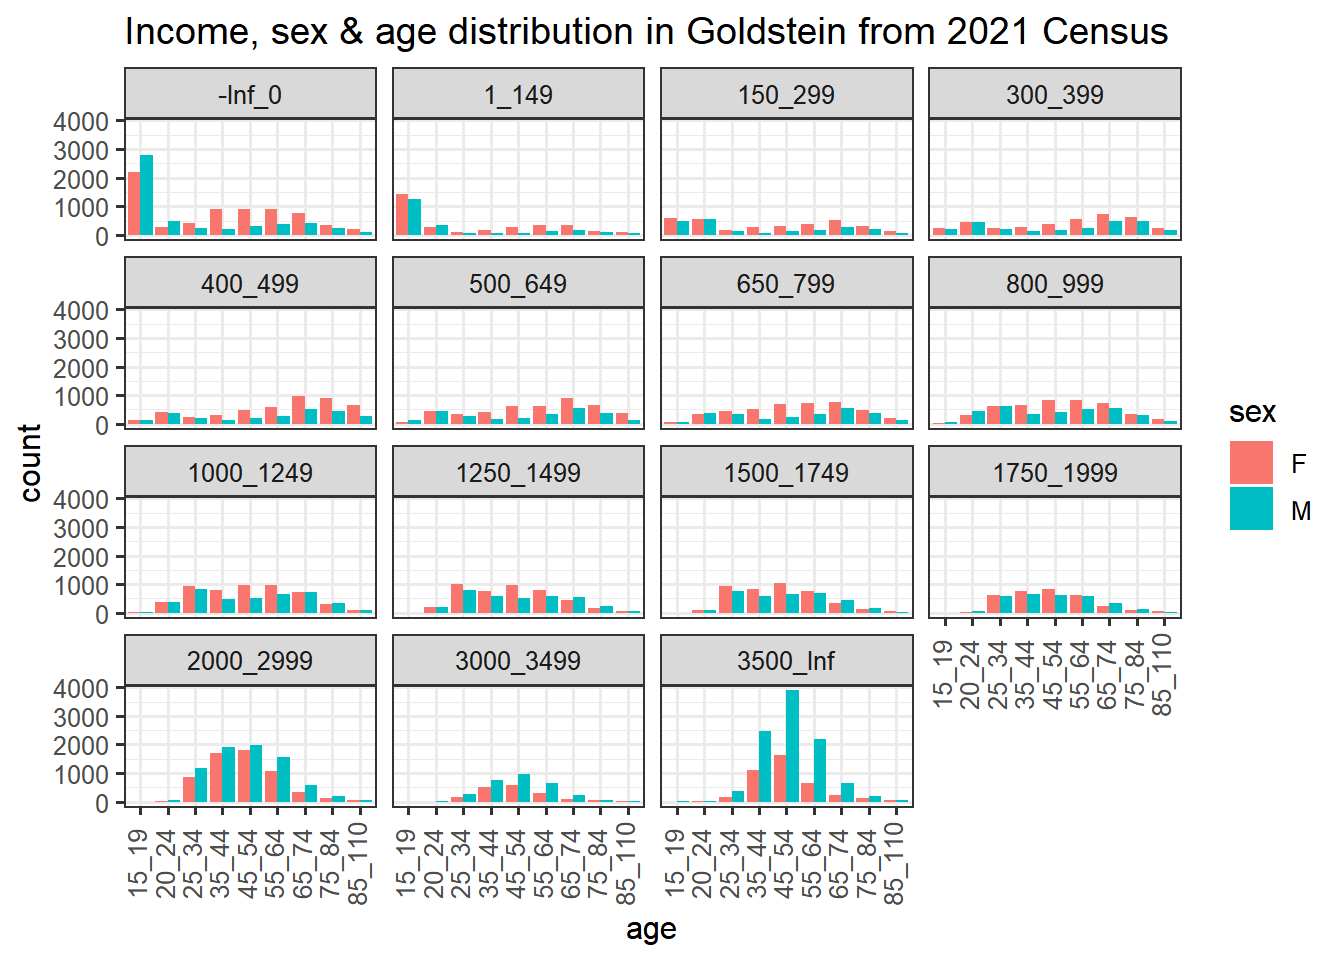

``` r
# Step 12: Create a plot for Victoria
tbl_G17_tidy %>%
  filter(sex != "P") |>
  ggplot(aes(x = age, y = count, fill = sex)) +
  geom_col(position = "dodge") +
  facet_wrap(~income) +
  theme_bw(base_size = 12) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.3)) +
  ggtitle("Income, sex & age distribution in Victoria from 2021 Census")
```

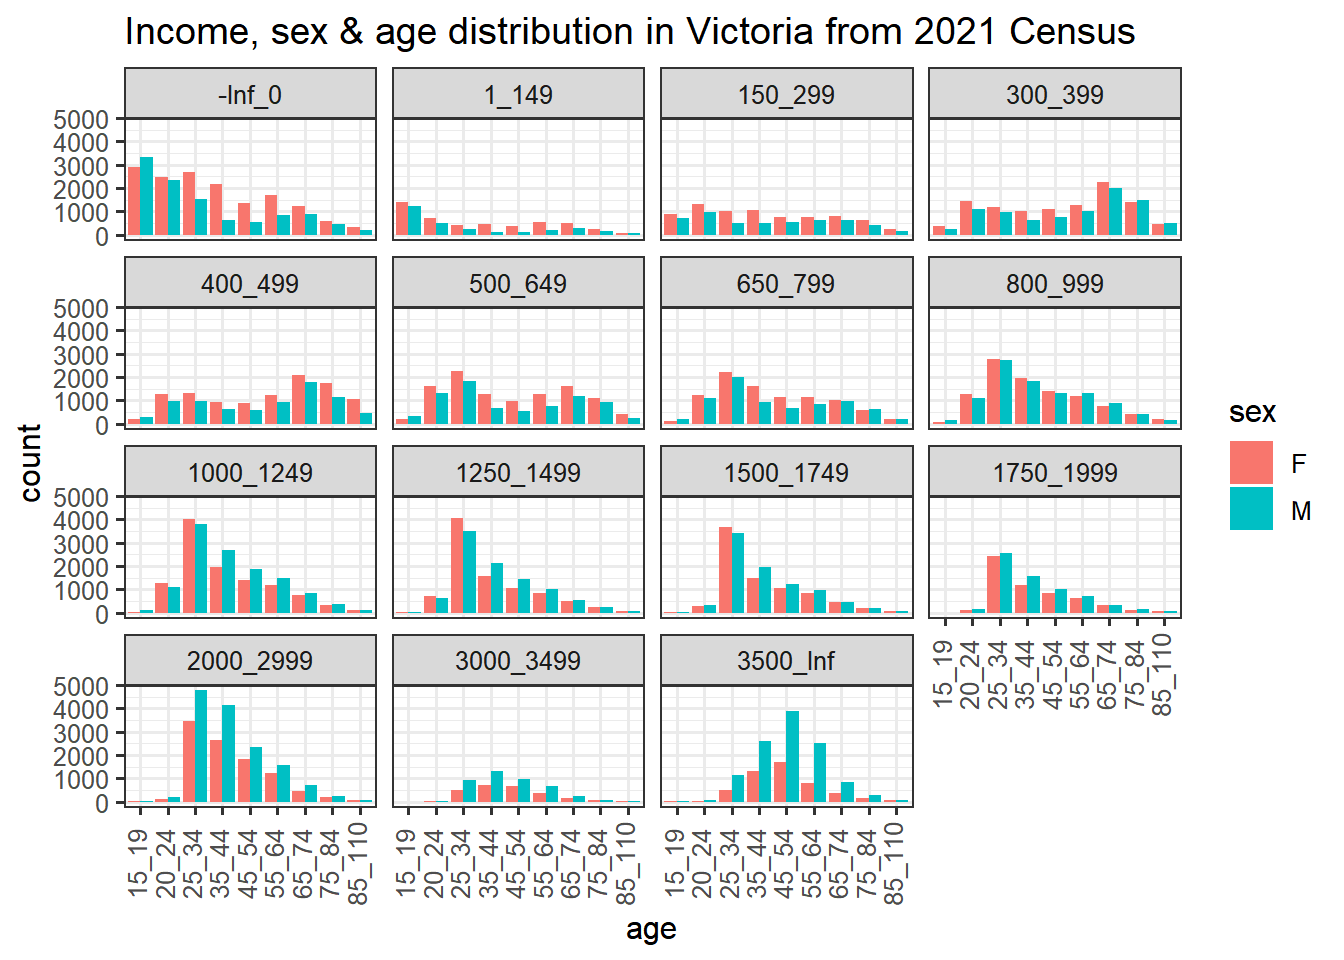

**Explanation for the steps**

The code explanation steps are provided in the RMD file. I opted to keep
the HTML output clear and structured, so the steps are hidden using
opts_chunk\$set.

**Assumptions**

Goldstein analysis reveals that the majority of individuals with no
income are typically between the ages of 15 and 19, as indicated by the
chart with 0 or fewer. Conversely, those with the highest income tend to
fall between the ages of 35 and 64, as shown in the chart with 3500 or
more. Additionally, in most of the other charts, females tend to earn
more than males, which is an interesting finding when compared to the
two charts previously mentioned.

Victoria analysis on the other hand reveals that the majority of
individuals with no income are typically between the ages of 15 and 74,
as indicated by the chart with 0 or fewer. Conversely, those with the
highest income tend to fall between the ages of 35 and 64 like
Goldstein, as shown in the chart with 3500 or more. Additionally, in
most of the other charts, females tend to earn more than males.

**Q4) (6 marks) Choose 2 variables of interest from the G02 census data.
Be sure to explain what your chosen variables are, where they came from
and why you think those variables are interesting for election politics.
Compare your electorate to the other electorates in that state. (Do not
use the same example of median_age_persons from the lectures). Below is
some code you may find useful to match SA1 regions and electorates.**

``` r
# Step 1: Read the shapefile
aec_map <- read_sf(here::here("data/vic-july-2021-esri/E_VIC21_region.shp"))

# Step 2: Read the votes data
votes <- read_csv("https://results.aec.gov.au/27966/Website/Downloads/HouseDopByDivisionDownload-27966.csv", skip = 1)

# Step 3: Generate electoral winners data
electoral_winners = election_data |>
  mutate(DivisionNm = toupper(DivisionNm)) |>
  filter(Elected == "Y") |>
  select(PartyAb, DivisionID, DivisionNm, Elected) |>
  distinct() 

# Step 4: Join map data with electoral winners
aec_map = aec_map |>
  mutate(Elect_div = toupper(Elect_div))
winners_with_map = electoral_winners |>
  left_join(aec_map, by = c("DivisionNm" = "Elect_div"))

# Step 5: Read and list layers
geopath_2021_G02 <- here::here("data/Geopackage_2021_G02_VIC_GDA2020/G02_VIC_GDA2020.gpkg")
st_layers(geopath_2021_G02) 
```

    ## Driver: GPKG 
    ## Available layers:
    ##            layer_name geometry_type features fields crs_name
    ## 1    G02_UCL_2021_VIC Multi Polygon      347     11  GDA2020
    ## 2    G02_SUA_2021_VIC Multi Polygon       22     11  GDA2020
    ## 3    G02_STE_2021_VIC Multi Polygon        1     11  GDA2020
    ## 4   G02_SOSR_2021_VIC Multi Polygon       12     11  GDA2020
    ## 5    G02_SOS_2021_VIC Multi Polygon        6     11  GDA2020
    ## 6    G02_SED_2021_VIC Multi Polygon       90     11  GDA2020
    ## 7    G02_SAL_2021_VIC Multi Polygon     2946     11  GDA2020
    ## 8    G02_SA4_2021_VIC Multi Polygon       19     11  GDA2020
    ## 9    G02_SA3_2021_VIC Multi Polygon       68     11  GDA2020
    ## 10   G02_SA2_2021_VIC Multi Polygon      524     11  GDA2020
    ## 11   G02_SA1_2021_VIC Multi Polygon    15482     11  GDA2020
    ## 12   G02_POA_2021_VIC Multi Polygon      694     11  GDA2020
    ## 13   G02_LGA_2021_VIC Multi Polygon       82     11  GDA2020
    ## 14 G02_GCCSA_2021_VIC Multi Polygon        4     11  GDA2020
    ## 15   G02_CED_2021_VIC Multi Polygon       41     11  GDA2020
    ## 16    G02_RA_2021_VIC Multi Polygon        6     11  GDA2020

``` r
# Step 6: Read SA1 data
vicmap_sed_G02 <- read_sf(geopath_2021_G02, layer = "G02_SED_2021_VIC")
vicmap_sed_G02$geom 
```

    ## Geometry set for 90 features  (with 2 geometries empty)
    ## Geometry type: MULTIPOLYGON
    ## Dimension:     XY
    ## Bounding box:  xmin: 140.9619 ymin: -39.15918 xmax: 149.9762 ymax: -33.98064
    ## Geodetic CRS:  GDA2020
    ## First 5 geometries:

``` r
# Step 7: Filter Goldstein electorate
electorate_goldstein <- winners_with_map |>
  filter(DivisionNm == "GOLDSTEIN")

# Step 8: Set projection to GDA1994 using EPSG:4283
st_crs(electorate_goldstein$geometry,4283)
```

    ## Coordinate Reference System:
    ##   User input: GDA94 
    ##   wkt:
    ## GEOGCRS["GDA94",
    ##     DATUM["Geocentric Datum of Australia 1994",
    ##         ELLIPSOID["GRS 1980",6378137,298.257222101,
    ##             LENGTHUNIT["metre",1]]],
    ##     PRIMEM["Greenwich",0,
    ##         ANGLEUNIT["degree",0.0174532925199433]],
    ##     CS[ellipsoidal,2],
    ##         AXIS["geodetic latitude (Lat)",north,
    ##             ORDER[1],
    ##             ANGLEUNIT["degree",0.0174532925199433]],
    ##         AXIS["geodetic longitude (Lon)",east,
    ##             ORDER[2],
    ##             ANGLEUNIT["degree",0.0174532925199433]],
    ##     USAGE[
    ##         SCOPE["Horizontal component of 3D system."],
    ##         AREA["Australia including Lord Howe Island, Macquarie Island, Ashmore and Cartier Islands, Christmas Island, Cocos (Keeling) Islands, Norfolk Island. All onshore and offshore."],
    ##         BBOX[-60.55,93.41,-8.47,173.34]],
    ##     ID["EPSG",4283]]

``` r
# Step 9: Transform projection from GDA1994 to GDA2020 using EPSG:7844
electorate_goldstein$geometry = st_transform(electorate_goldstein$geometry, 7844)
sed_intersect_goldstein <- vicmap_sed_G02 |>
  filter(st_intersects(geom,
    electorate_goldstein$geometry,
    sparse = FALSE
  )[, 1]) 

# Step 10: Filter Indi electorate
electorate_indi <- winners_with_map |>
  filter(DivisionNm == "INDI")

# Step 11: Set projection to GDA1994 using EPSG:4283
st_crs(electorate_indi$geometry,4283)
```

    ## Coordinate Reference System:
    ##   User input: GDA94 
    ##   wkt:
    ## GEOGCRS["GDA94",
    ##     DATUM["Geocentric Datum of Australia 1994",
    ##         ELLIPSOID["GRS 1980",6378137,298.257222101,
    ##             LENGTHUNIT["metre",1]]],
    ##     PRIMEM["Greenwich",0,
    ##         ANGLEUNIT["degree",0.0174532925199433]],
    ##     CS[ellipsoidal,2],
    ##         AXIS["geodetic latitude (Lat)",north,
    ##             ORDER[1],
    ##             ANGLEUNIT["degree",0.0174532925199433]],
    ##         AXIS["geodetic longitude (Lon)",east,
    ##             ORDER[2],
    ##             ANGLEUNIT["degree",0.0174532925199433]],
    ##     USAGE[
    ##         SCOPE["Horizontal component of 3D system."],
    ##         AREA["Australia including Lord Howe Island, Macquarie Island, Ashmore and Cartier Islands, Christmas Island, Cocos (Keeling) Islands, Norfolk Island. All onshore and offshore."],
    ##         BBOX[-60.55,93.41,-8.47,173.34]],
    ##     ID["EPSG",4283]]

``` r
# Step 12: Transform projection from GDA1994 to GDA2020 using EPSG:7844
electorate_indi$geometry = st_transform(electorate_indi$geometry, 7844)
sed_intersect_indi <- vicmap_sed_G02 |>
  filter(st_intersects(geom,
    electorate_indi$geometry,
    sparse = FALSE
  )[, 1]) 

# Step 13: Filter Kooyong electorate
electorate_kooyong <- winners_with_map |>
  filter(DivisionNm == "KOOYONG")

# Step 14: Set projection to GDA1994 using EPSG:4283
st_crs(electorate_kooyong$geometry,4283)
```

    ## Coordinate Reference System:
    ##   User input: GDA94 
    ##   wkt:
    ## GEOGCRS["GDA94",
    ##     DATUM["Geocentric Datum of Australia 1994",
    ##         ELLIPSOID["GRS 1980",6378137,298.257222101,
    ##             LENGTHUNIT["metre",1]]],
    ##     PRIMEM["Greenwich",0,
    ##         ANGLEUNIT["degree",0.0174532925199433]],
    ##     CS[ellipsoidal,2],
    ##         AXIS["geodetic latitude (Lat)",north,
    ##             ORDER[1],
    ##             ANGLEUNIT["degree",0.0174532925199433]],
    ##         AXIS["geodetic longitude (Lon)",east,
    ##             ORDER[2],
    ##             ANGLEUNIT["degree",0.0174532925199433]],
    ##     USAGE[
    ##         SCOPE["Horizontal component of 3D system."],
    ##         AREA["Australia including Lord Howe Island, Macquarie Island, Ashmore and Cartier Islands, Christmas Island, Cocos (Keeling) Islands, Norfolk Island. All onshore and offshore."],
    ##         BBOX[-60.55,93.41,-8.47,173.34]],
    ##     ID["EPSG",4283]]

``` r
# Step 15: Transform projection from GDA1994 to GDA2020 using EPSG:7844
electorate_kooyong$geometry = st_transform(electorate_kooyong$geometry, 7844)
sed_intersect_kooyong <- vicmap_sed_G02 |>
  filter(st_intersects(geom,
    electorate_kooyong$geometry,
    sparse = FALSE
  )[, 1]) 

# Step 16: Calculate intersection for Goldstein
sed_intersect2_goldstein <- sed_intersect_goldstein |>
  mutate(
    geometry = st_intersection(geom, electorate_goldstein$geometry),
    perc_area = 100 * st_area(geometry) / st_area(geom),
    perc_area = as.numeric(perc_area)
  ) |>
  filter(perc_area > 5) 

# Step 17: Calculate intersection for Indi
sed_intersect2_indi <- sed_intersect_indi |>
  mutate(
    geometry = st_intersection(geom, electorate_indi$geometry),
    geometry = st_make_valid(geometry),  # Fix invalid geometries
    perc_area = 100 * st_area(geometry) / st_area(geom),
    perc_area = as.numeric(perc_area)
  ) |>
  filter(perc_area > 5)

# Step 18: Calculate intersection for Kooyong
sed_intersect2_kooyong <- sed_intersect_kooyong |>
  mutate(
    geometry = st_intersection(geom, electorate_kooyong$geometry),
    perc_area = 100 * st_area(geometry) / st_area(geom),
    perc_area = as.numeric(perc_area)
  ) |>
  filter(perc_area > 5) 

# Step 19: Read SA1 data for G02 layer
vicmap_sa1_G02 <- read_sf(geopath_2021_G02, layer = "G02_SA1_2021_VIC")

# Step 20: Filter SA1 intersection for Goldstein
sa1_intersect_goldstein <- vicmap_sa1_G02 %>%
  filter(st_intersects(geom,
    electorate_goldstein$geometry,
    sparse = FALSE
  )[, 1])

# Step 21: Filter SA1 intersection for Indi
sa1_intersect_indi <- vicmap_sa1_G02 %>%
  filter(st_intersects(geom,
    electorate_indi$geometry,
    sparse = FALSE
  )[, 1])

# Step 22: Filter SA1 intersection for Kooyong
sa1_intersect_kooyong <- vicmap_sa1_G02 %>%
  filter(st_intersects(geom,
    electorate_kooyong$geometry,
    sparse = FALSE
  )[, 1])

# Step 23: Calculate SA1 intersection for Goldstein
sa1_intersect2_goldstein <- sa1_intersect_goldstein %>%
  mutate(
    geometry = st_intersection(geom, electorate_goldstein$geometry),
    perc_area = 100 * st_area(geometry) / st_area(geom),
    perc_area = as.numeric(perc_area)
  ) %>%
  filter(perc_area > 5)

# Step 24: Calculate SA1 intersection for Indi
sa1_intersect2_indi <- sa1_intersect_indi %>%
  filter(st_is_valid(geom)) %>%
  mutate(
    geometry = st_intersection(geom, electorate_indi$geometry),
    geometry = st_make_valid(geometry),
    perc_area = 100 * st_area(geometry) / st_area(geom),
    perc_area = as.numeric(perc_area)
  ) %>%
  filter(perc_area > 5)

# Step 25: Calculate SA1 intersection for Kooyong
sa1_intersect2_kooyong <- sa1_intersect_kooyong %>%
  mutate(
    geometry = st_intersection(geom, electorate_kooyong$geometry),
    perc_area = 100 * st_area(geometry) / st_area(geom),
    perc_area = as.numeric(perc_area)
  ) %>%
  filter(perc_area > 5)

# Step 26: Combine all data into one dataframe
combined_data <- rbind(
  transform(sa1_intersect2_goldstein, area = "Goldstein"),
  transform(sa1_intersect2_indi, area = "Indi"),
  transform(sa1_intersect2_kooyong, area = "Kooyong")
)

# Step 27: Plot Median Mortgage Repayment Monthly
ggplot(combined_data, aes(x = Median_mortgage_repay_monthly)) +
  geom_histogram(binwidth = 20) +
  facet_wrap(~ area, nrow = 3) +
  labs(x = "Median Mortgage Repayment Monthly", y = "Frequency") +
  theme_minimal()
```

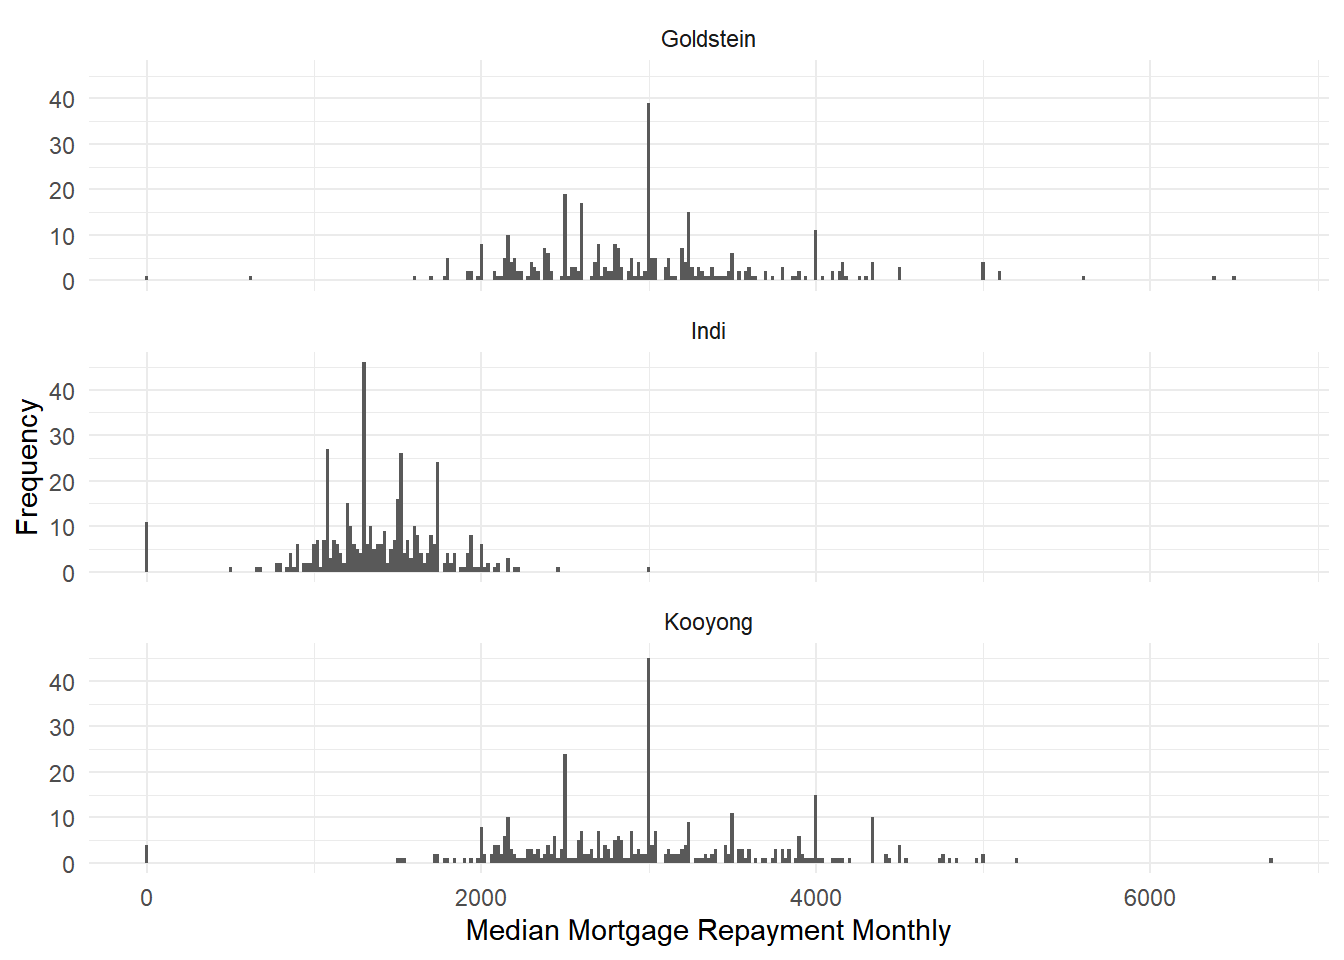

``` r
# Step 28: Plot Median Total Personal Income Weekly
ggplot(combined_data, aes(x = Median_tot_prsnl_inc_weekly)) +
  geom_histogram(binwidth = 20) +
  facet_wrap(~ area, nrow = 3) +
  labs(x = "Median Total Personal Income Weekly", y = "Frequency") +
  theme_minimal()
```

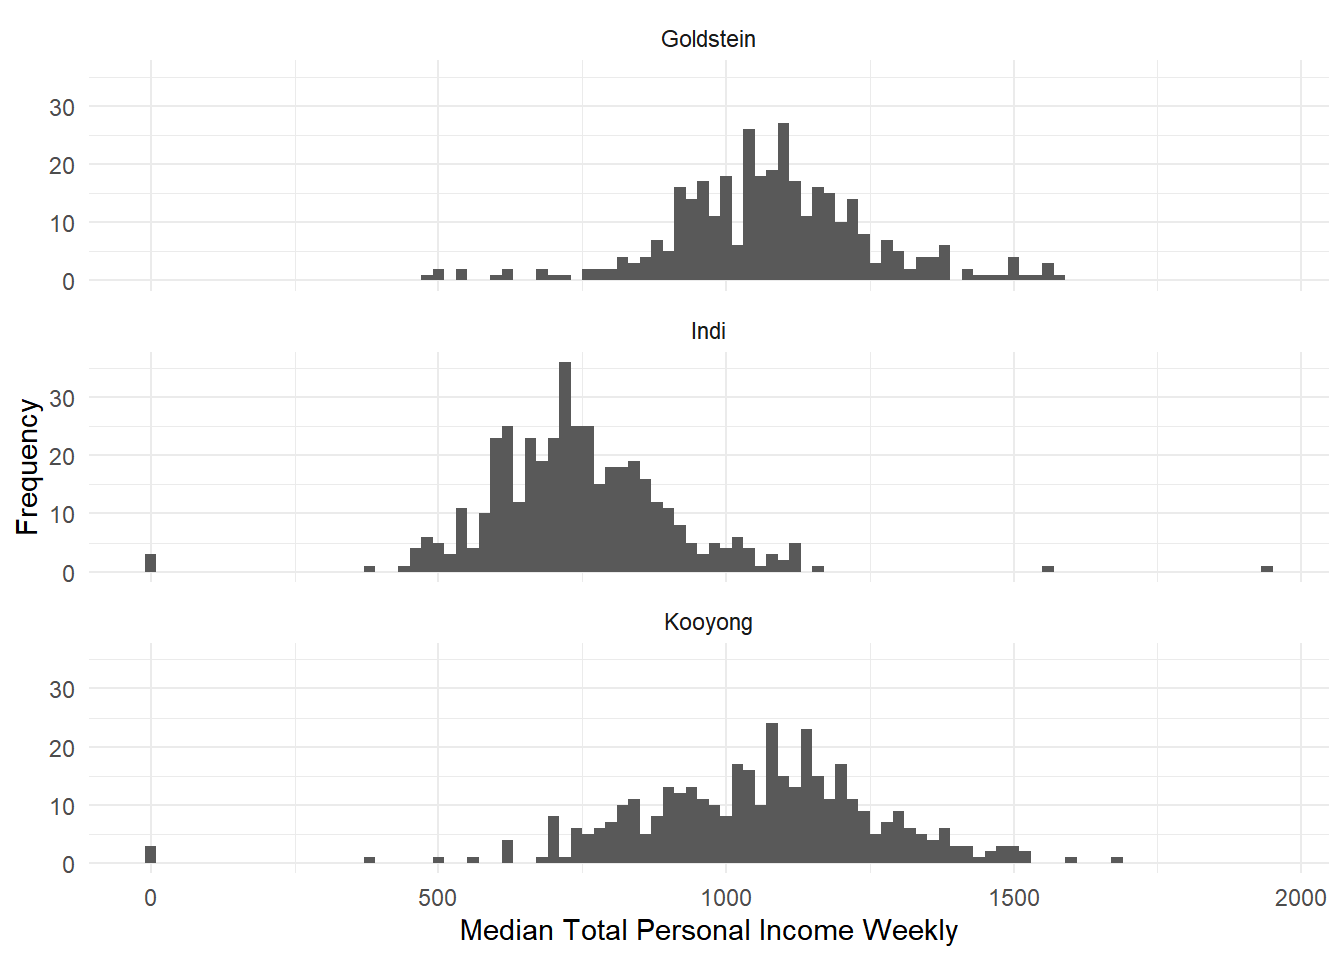

**Variables explanation & importance for the election politics**

The selected variables for this analysis are “Median Mortgage Repayment
Monthly” and “Median Total Personal Income Weekly.” These variables are
derived from census data, which provide valuable insights into the
economic landscape and household finances.

***Median Mortgage Repayment Monthly***:

This variable represents the median amount paid by individuals or
households on a monthly basis for mortgage repayment. It’s a crucial
factor for election politics as it reflects the financial strain on
homeowners, impacting their economic stability and overall satisfaction
with the government’s housing policies. During election periods,
understanding the trends in mortgage repayment can help politicians
shape housing policies and connect with voters concerned about the cost
of living and housing affordability.

***Median Total Personal Income Weekly***:

This variable represents the median total personal income earned by
individuals on a weekly basis. It’s significant for election politics as
it directly reflects the economic prosperity and financial well-being of
the voters. Understanding the trends in personal income can assist
politicians in crafting economic policies that resonate with voters and
address concerns about income inequality, job creation, and wage growth.

These variables are interesting for election politics because they shed
light on two critical aspects of voters’ lives: their ability to afford
housing and their overall financial well-being. By understanding these
variables, politicians can tailor their policies and campaign promises
to better address the needs and concerns of the electorate. Moreover,
analyzing the relationship between these variables can provide insights
into the economic trends of different demographics, thereby influencing
election strategies and policy platforms.

**Q5) (3.5 marks) In 2023, Australia held a referendum to decide whether
there should be an indigenous voice to parliament (Yes Campaign, Youtube
Explainer, No Campaign). What was the percentage yes vote in your chosen
electorate? What census variable(s) do I need to look at to determine
the percentage of people who are Indigenous and Torres Strait Islanders
in my electorate? The datapack for these variables is not available for
SA1 regions, why might this be?**

``` r
# Step 1: Read the yes vote data
yes_vote <- read.csv("https://results.aec.gov.au/29581/Website/Downloads/ReferendumPollingPlaceResultsByStateDownload-29581-VIC.csv", skip = 1)

# Step 2: Calculate the mean yes percentage for Goldstein
yes_vote |>
  filter(DivisionName == "Goldstein") %>%
  summarise(mean_yes_percentage = mean(YesPercentage))
```

    ##   mean_yes_percentage
    ## 1            60.07705

``` r
# Step 3: Read and list layers
geopath_2021_G07 <- here::here("data/Geopackage_2021_G07_VIC_GDA2020/G07_VIC_GDA2020.gpkg")
st_layers(geopath_2021_G07) 
```

    ## Driver: GPKG 
    ## Available layers:
    ##            layer_name geometry_type features fields crs_name
    ## 1  G07_GCCSA_2021_VIC Multi Polygon        4    183  GDA2020
    ## 2    G07_UCL_2021_VIC Multi Polygon      347    183  GDA2020
    ## 3    G07_SUA_2021_VIC Multi Polygon       22    183  GDA2020
    ## 4   G07_SOSR_2021_VIC Multi Polygon       12    183  GDA2020
    ## 5    G07_SOS_2021_VIC Multi Polygon        6    183  GDA2020
    ## 6    G07_CED_2021_VIC Multi Polygon       41    183  GDA2020
    ## 7    G07_LGA_2021_VIC Multi Polygon       82    183  GDA2020
    ## 8    G07_POA_2021_VIC Multi Polygon      694    183  GDA2020
    ## 9    G07_SA1_2021_VIC Multi Polygon    15482    183  GDA2020
    ## 10   G07_SA2_2021_VIC Multi Polygon      524    183  GDA2020
    ## 11   G07_SA3_2021_VIC Multi Polygon       68    183  GDA2020
    ## 12   G07_SA4_2021_VIC Multi Polygon       19    183  GDA2020
    ## 13   G07_SAL_2021_VIC Multi Polygon     2946    183  GDA2020
    ## 14   G07_SED_2021_VIC Multi Polygon       90    183  GDA2020
    ## 15   G07_STE_2021_VIC Multi Polygon        1    183  GDA2020
    ## 16    G07_RA_2021_VIC Multi Polygon        6    183  GDA2020

``` r
# Step 4: Read CED data
vicmap_ced_G07 <- read_sf(geopath_2021_G07, layer = "G07_CED_2021_VIC")
vicmap_ced_G07$geom
```

    ## Geometry set for 41 features  (with 2 geometries empty)
    ## Geometry type: MULTIPOLYGON
    ## Dimension:     XY
    ## Bounding box:  xmin: 140.9619 ymin: -39.15918 xmax: 149.9762 ymax: -33.98064
    ## Geodetic CRS:  GDA2020
    ## First 5 geometries:

``` r
# Step 5: Transform Goldstein electorate projection
electorate_goldstein$geometry = st_transform(electorate_goldstein$geometry, 7844)
ced_intersect_goldstein <- vicmap_ced_G07 |>
  filter(st_intersects(geom,
    electorate_goldstein$geometry,
    sparse = FALSE
  )[, 1])  

# Step 6: Read SA1 data for G07 layer
vicmap_sa1_G07 <- read_sf(geopath_2021_G07, layer = "G07_SA1_2021_VIC")

# Step 7: Filter SA1 intersection for Goldstein
sa1_intersect_goldstein <- vicmap_sa1_G07 %>%
  filter(st_intersects(geom,
    electorate_goldstein$geometry,
    sparse = FALSE
  )[, 1])

# Step 8: Read the data
IP_percentage <- vicmap_ced_G07 %>%
  filter(CED_NAME_2021 == "Goldstein") %>%
  select(Tot_Indigenous_M, Tot_Indigenous_F, Tot_Indigenous_P)

# Step 9: Reshape the data
IP_percentage <- IP_percentage %>%
  pivot_longer(cols = 1:3,
               names_to = "gender",
               values_to = "count")

# Step 10: Calculate the total count of Indigenous and Torres Strait Islanders
total_count <- sum(IP_percentage$count)

# Step 11: Calculate the percentage
IP_percentage <- IP_percentage %>%
  mutate(percentage = (count / total_count) * 100)

# Step 12: Plot the data
IP_percentage %>% 
  ggplot(aes(x = gender, y = percentage, fill = gender)) +
  geom_col() +
  labs(title = "Percentage of Indigenous and Torres Strait Islanders in Goldstein",
       x = "Gender",
       y = "Percentage") 
```

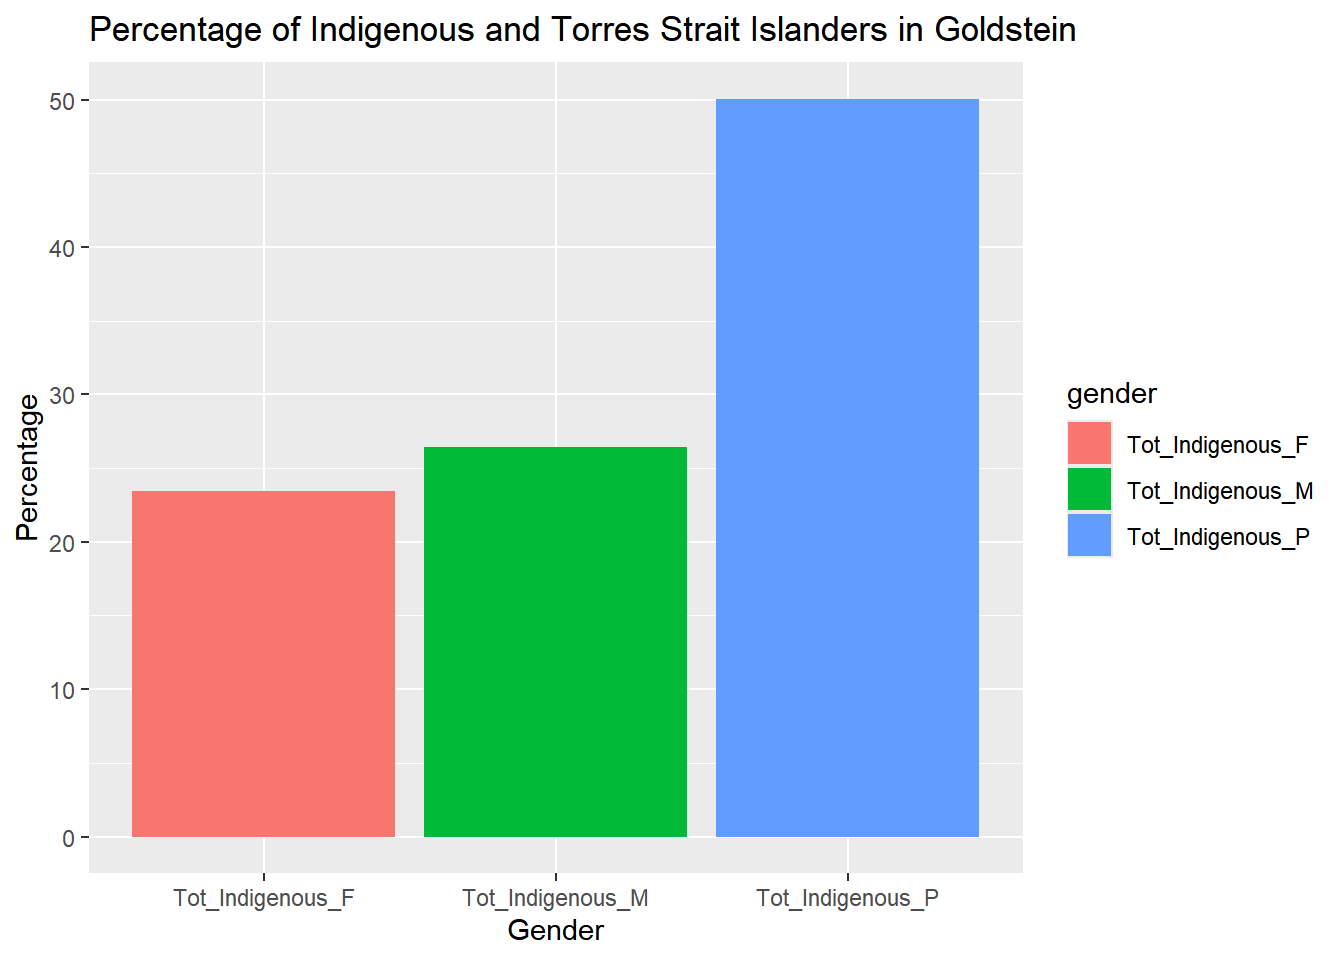

**Unavailability for SA1 regions**

The Australian Bureau of Statistics (ABS) has restricted the release of
data pertaining to Indigenous and Torres Strait Islanders for SA1
regions due to privacy and confidentiality concerns. The ABS has taken
this step to ensure that the privacy and confidentiality of respondents
is not compromised, and releasing such data for small areas could pose a
risk to this.

**Q6) (1 marks) Based on your analysis, is your chosen electorate
representative of the broader state population?**

After conducting an analysis of age, sex, mortgage repayment, and income
distribution data, it can be seen that Goldstein is not too far off from
the state averages. There are some slight variations, but overall, the
data indicates that Goldstein can be considered a reasonable
representation of the broader population in the state.

# References

Goldstein electorate boundary shapefile: Australian Electoral Commission
(AEC). (2021). E_VIC21_region.
<https://www.aec.gov.au/Electorates/gis/gis_datadownload.htm>

Victoria SA1 census data: Australian Bureau of Statistics (ABS). (2021).
2021 Census GCP All Geographies for VIC.
<https://www.abs.gov.au/websitedbs/censushome.nsf/home/datapacks>

2022 Federal Election Voter Data: Australian Electoral Commission (AEC).
(2022). HouseDopByDivisionDownload-27966.csv.
<https://results.aec.gov.au/27966/Website/Downloads/HouseDopByDivisionDownload-27966.csv>

2019 Federal Election Voter Data: Australian Electoral Commission (AEC).
(2019). HouseDopByDivisionDownload-24310.csv.
<https://results.aec.gov.au/24310/Website/Downloads/HouseDopByDivisionDownload-24310.csv>

Referendum Polling Place Results: Australian Electoral Commission (AEC).
(2023). ReferendumPollingPlaceResultsByStateDownload-29581-VIC.csv.
<https://results.aec.gov.au/29581/Website/Downloads/ReferendumPollingPlaceResultsByStateDownload-29581-VIC.csv>

2021 Census Data: Australian Bureau of Statistics (ABS). (2021).
Geopackage_2021_G02_VIC_GDA2020.
<https://www.abs.gov.au/websitedbs/censushome.nsf/home/datapacks>

2016 Census Data: Australian Bureau of Statistics (ABS). (2016).
Geopackage_2021_G07_VIC_GDA2020.
<https://www.abs.gov.au/websitedbs/censushome.nsf/home/datapacks>

YouTube Explainer (Yes Campaign): Australian Electoral Commission (AEC).
(2023). Yes Campaign. <https://www.youtube.com/watch?v=videoID>

YouTube Explainer (No Campaign): Australian Electoral Commission (AEC).
(2023). No Campaign. <https://www.youtube.com/watch?v=videoID>

Wickham H, Averick M, Bryan J, Chang W, McGowan LD, François R,
Grolemund G, Hayes A, Henry L, Hester J, Kuhn M, Pedersen TL, Miller E,
Bache SM, Müller K, Ooms J, Robinson D, Seidel DP, Spinu V, Takahashi K,
Vaughan D, Wilke C, Woo K, Yutani H (2019). “Welcome to the tidyverse.”
*Journal of Open Source Software*, *4*(43), 1686.
<doi:10.21105/joss.01686> <https://doi.org/10.21105/joss.01686>.

Pebesma, E., & Bivand, R. (2023). Spatial Data Science: With
Applications in R. Chapman and Hall/CRC.
<https://doi.org/10.1201/9780429459016>

Müller K (2020). *here: A Simpler Way to Find Your Files*. R package
version 1.0.1, <https://CRAN.R-project.org/package=here>.